# Install and import library

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# Evaluation function:

In [ ]:
def evaluation(y_test, y_pred):
  print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')
  print(f'MAPE = {mean_absolute_percentage_error(y_test, y_pred)*100}')
  print(f'MAE = {mean_absolute_error(y_test, y_pred)}')

# Preprocessing Dataset

In [ ]:
df = pd.read_csv('/content/CMG.csv')

In [ ]:
df

,Date,Price
0,12/15/2016,9602.3
1,12/16/2016,9352.8
2,12/19/2016,9352.8
3,12/21/2016,9415.2
4,12/23/2016,9321.7
...,...,...
1739,12/11/2023,38850.0
1740,12/12/2023,39000.0
1741,12/13/2023,38900.0
1742,12/14/2023,38900.0


In [ ]:
list_reference_date = [datetime.strptime(date_str, '%m/%d/%Y') for date_str in df['Date']]

In [ ]:
reference_date = min(list_reference_date)
from datetime import datetime
df['numerical_date'] = df['Date'].apply(lambda x: (datetime.strptime(x, '%m/%d/%Y') - reference_date).days)

In [ ]:
df_ = df['Price'].values.reshape(-1, 1)

In [ ]:
scaler = MinMaxScaler()
df['Price'] = scaler.fit_transform(df_)
df1= df['Price'].copy()

In [ ]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

# Split train, test

In [ ]:
def split_data(train_ratio, test_ratio):
  train_size = int(train_ratio * len(df1))
  test_size = int(test_ratio * len(df1))

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size].reset_index(drop=True)
  return train_size, test_size, train_data, test_data

# **BNN**

## Split data 7:3


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.7, 0.3)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9608755707740784
Epoch 2/500, Loss: 0.9209585189819336
Epoch 3/500, Loss: 0.920105516910553
Epoch 4/500, Loss: 0.9192907810211182
Epoch 5/500, Loss: 0.9191479086875916
Epoch 6/500, Loss: 0.9192177653312683
Epoch 7/500, Loss: 0.9191628694534302
Epoch 8/500, Loss: 0.9196712374687195
Epoch 9/500, Loss: 0.9192655682563782
Epoch 10/500, Loss: 0.9192082285881042
Epoch 11/500, Loss: 0.919156551361084
Epoch 12/500, Loss: 0.9190628528594971
Epoch 13/500, Loss: 0.9193553924560547
Epoch 14/500, Loss: 0.9190802574157715
Epoch 15/500, Loss: 0.9190803170204163
Epoch 16/500, Loss: 0.9191073179244995
Epoch 17/500, Loss: 0.9192570447921753
Epoch 18/500, Loss: 0.9194380044937134
Epoch 19/500, Loss: 0.9191939234733582
Epoch 20/500, Loss: 0.9190970659255981
Epoch 21/500, Loss: 0.9191160202026367
Epoch 22/500, Loss: 0.9190660715103149
Epoch 23/500, Loss: 0.9190974235534668
Epoch 24/500, Loss: 0.9191455245018005
Epoch 25/500, Loss: 0.9190919399261475
Epoch 26/500, Loss: 0.91904401779174

In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.5596634149551392, 0.5483496189117432, 0.5410986542701721, 0.5279207825660706, 0.5159812569618225, 0.4981422424316406, 0.48340314626693726, 0.4614149332046509, 0.4485430121421814, 0.4394025206565857, 0.42453330755233765, 0.4168650507926941, 0.41231876611709595, 0.4155101180076599, 0.4107248783111572, 0.41058844327926636, 0.40854573249816895, 0.41393589973449707, 0.40087538957595825, 0.38893580436706543, 0.37624591588974, 0.36498671770095825, 0.36084556579589844, 0.3474438786506653, 0.33997753262519836, 0.3281571567058563, 0.32227325439453125, 0.31178152561187744, 0.30312055349349976, 0.300293505191803]


In [ ]:
forecasted_next_30_days

[0.5596634149551392,
 0.5483496189117432,
 0.5410986542701721,
 0.5279207825660706,
 0.5159812569618225,
 0.4981422424316406,
 0.48340314626693726,
 0.4614149332046509,
 0.4485430121421814,
 0.4394025206565857,
 0.42453330755233765,
 0.4168650507926941,
 0.41231876611709595,
 0.4155101180076599,
 0.4107248783111572,
 0.41058844327926636,
 0.40854573249816895,
 0.41393589973449707,
 0.40087538957595825,
 0.38893580436706543,
 0.37624591588974,
 0.36498671770095825,
 0.36084556579589844,
 0.3474438786506653,
 0.33997753262519836,
 0.3281571567058563,
 0.32227325439453125,
 0.31178152561187744,
 0.30312055349349976,
 0.300293505191803]

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 1834.3339342749962
MAPE = 3.4470316856271674
MAE = 1527.1959650844194


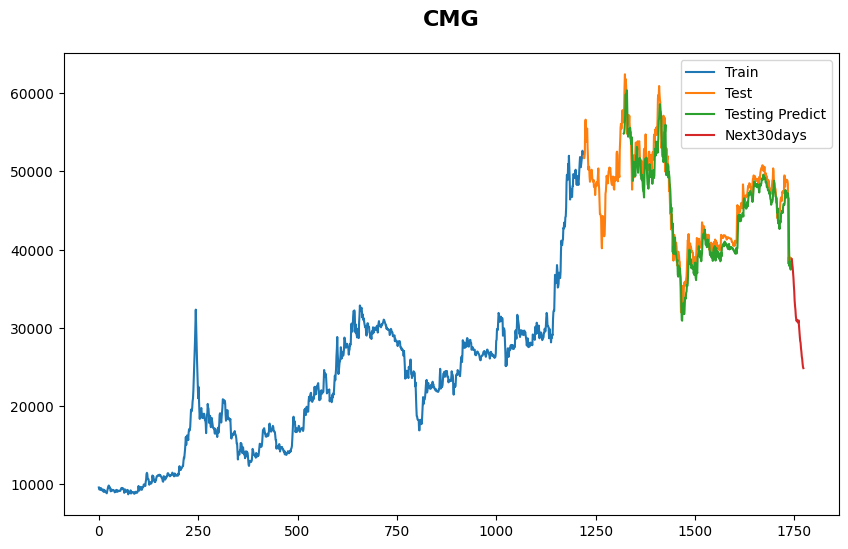

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('CMG', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()


## Split data 8:2


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.8, 0.2)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9529032111167908
Epoch 2/500, Loss: 0.9208055734634399
Epoch 3/500, Loss: 0.9194450378417969
Epoch 4/500, Loss: 0.9196470975875854
Epoch 5/500, Loss: 0.9192309975624084
Epoch 6/500, Loss: 0.9192852973937988
Epoch 7/500, Loss: 0.9203685522079468
Epoch 8/500, Loss: 0.9194496273994446
Epoch 9/500, Loss: 0.9191722869873047
Epoch 10/500, Loss: 0.9198322296142578
Epoch 11/500, Loss: 0.9190852642059326
Epoch 12/500, Loss: 0.9195573329925537
Epoch 13/500, Loss: 0.9191172122955322
Epoch 14/500, Loss: 0.9191328883171082
Epoch 15/500, Loss: 0.9190794229507446
Epoch 16/500, Loss: 0.9191634058952332
Epoch 17/500, Loss: 0.9190117120742798
Epoch 18/500, Loss: 0.9192094802856445
Epoch 19/500, Loss: 0.9190546870231628
Epoch 20/500, Loss: 0.9190276265144348
Epoch 21/500, Loss: 0.919222891330719
Epoch 22/500, Loss: 0.91923987865448
Epoch 23/500, Loss: 0.9193251729011536
Epoch 24/500, Loss: 0.9192069172859192
Epoch 25/500, Loss: 0.9191032648086548
Epoch 26/500, Loss: 0.919066548347473

In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.5681129693984985, 0.5771534442901611, 0.5745848417282104, 0.5722236037254333, 0.5733630061149597, 0.5844321846961975, 0.5965775847434998, 0.5993006825447083, 0.6071887612342834, 0.6245101094245911, 0.6250988245010376, 0.620583176612854, 0.6190840601921082, 0.6266836524009705, 0.6255199313163757, 0.6244366765022278, 0.610569417476654, 0.6177491545677185, 0.6103048324584961, 0.6045411229133606, 0.5963833928108215, 0.5891017317771912, 0.5932064652442932, 0.5891112685203552, 0.5801136493682861, 0.5687624216079712, 0.5637455582618713, 0.5508238077163696, 0.5484703183174133, 0.5545423626899719]


In [ ]:
scaler.inverse_transform(forecasted_next_30_days_reshaped)

array([[38783.61714748],
       [38176.05838029],
       [37786.67650337],
       [37079.01556835],
       [36437.85468573],
       [35479.88711815],
       [34688.38733674],
       [33507.60490354],
       [32816.37373214],
       [32325.52294102],
       [31527.03578888],
       [31115.2450331 ],
       [30871.10636362],
       [31042.48419409],
       [30785.51347272],
       [30778.18681601],
       [30668.49181716],
       [30957.94757087],
       [30256.589033  ],
       [29615.42494957],
       [28933.96905542],
       [28329.34223124],
       [28106.95947514],
       [27387.27949426],
       [26986.33148625],
       [26351.56902511],
       [26035.59935226],
       [25472.18617243],
       [25007.08590699],
       [24855.27143425]])

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 1069.7756052520072
MAPE = 1.5917180462500118
MAE = 706.7574329453441


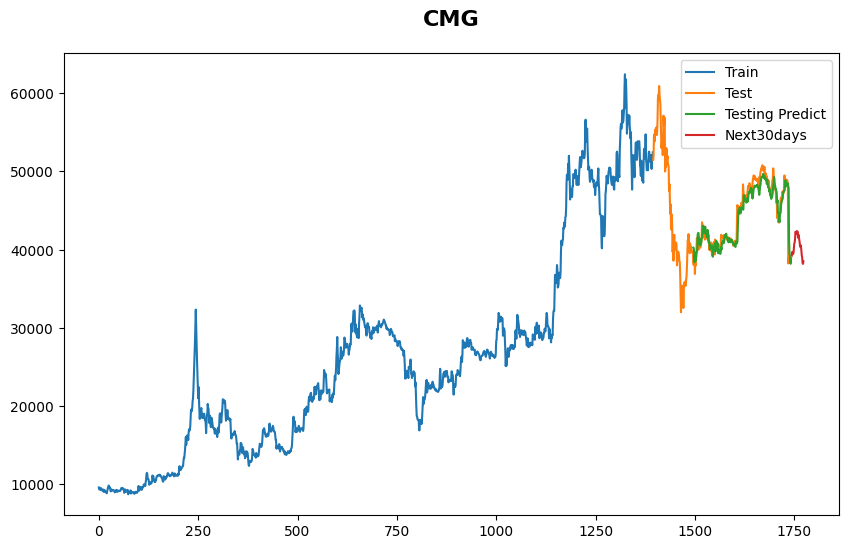

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('CMG', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()


## Split data 9:1


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.9, 0.1)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9503830075263977
Epoch 2/500, Loss: 0.9207828044891357
Epoch 3/500, Loss: 0.9199121594429016
Epoch 4/500, Loss: 0.9197536110877991
Epoch 5/500, Loss: 0.9194860458374023
Epoch 6/500, Loss: 0.9194900989532471
Epoch 7/500, Loss: 0.9198976755142212
Epoch 8/500, Loss: 0.9193235039710999
Epoch 9/500, Loss: 0.9195033311843872
Epoch 10/500, Loss: 0.919718861579895
Epoch 11/500, Loss: 0.9191243052482605
Epoch 12/500, Loss: 0.9198251962661743
Epoch 13/500, Loss: 0.919244647026062
Epoch 14/500, Loss: 0.9196495413780212
Epoch 15/500, Loss: 0.9193398356437683
Epoch 16/500, Loss: 0.9196277856826782
Epoch 17/500, Loss: 0.9190813899040222
Epoch 18/500, Loss: 0.9194623231887817
Epoch 19/500, Loss: 0.9196851253509521
Epoch 20/500, Loss: 0.9191794395446777
Epoch 21/500, Loss: 0.9192056059837341
Epoch 22/500, Loss: 0.9190576076507568
Epoch 23/500, Loss: 0.9193326234817505
Epoch 24/500, Loss: 0.9190075397491455
Epoch 25/500, Loss: 0.9194166660308838
Epoch 26/500, Loss: 0.91907024383544

In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.5901743769645691, 0.6073051691055298, 0.6171385645866394, 0.6307651996612549, 0.646216094493866, 0.6627677083015442, 0.6779628396034241, 0.6932660937309265, 0.7096056342124939, 0.7298938632011414, 0.7461171746253967, 0.7567647099494934, 0.7673302292823792, 0.7849050760269165, 0.803780734539032, 0.8175593614578247, 0.8272636532783508, 0.8460769057273865, 0.850213348865509, 0.8608538508415222, 0.8642851114273071, 0.8713660836219788, 0.8853412866592407, 0.8866023421287537, 0.8904716372489929, 0.8979348540306091, 0.9095434546470642, 0.9194852709770203, 0.9363991022109985, 0.9598639607429504]


In [ ]:
forecasted_next_30_days

[0.5901743769645691,
 0.6073051691055298,
 0.6171385645866394,
 0.6307651996612549,
 0.646216094493866,
 0.6627677083015442,
 0.6779628396034241,
 0.6932660937309265,
 0.7096056342124939,
 0.7298938632011414,
 0.7461171746253967,
 0.7567647099494934,
 0.7673302292823792,
 0.7849050760269165,
 0.803780734539032,
 0.8175593614578247,
 0.8272636532783508,
 0.8460769057273865,
 0.850213348865509,
 0.8608538508415222,
 0.8642851114273071,
 0.8713660836219788,
 0.8853412866592407,
 0.8866023421287537,
 0.8904716372489929,
 0.8979348540306091,
 0.9095434546470642,
 0.9194852709770203,
 0.9363991022109985,
 0.9598639607429504]

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 2001.0484460773769
MAPE = 2.9566492903984196
MAE = 1427.133026541096


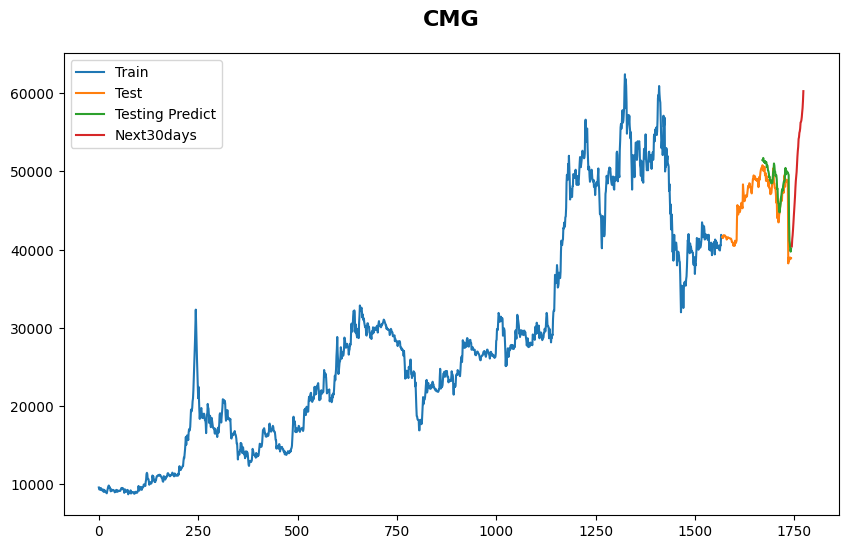

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('CMG', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()
